In [61]:
import numpy as np
import matplotlib.pyplot as plt
from world import Patch, Agent
from random import shuffle

In [128]:
# Function to initialize patches with random distribution among types
def initialize_patches(num_patches=100):
    yields = {'low': 32.5, 'med': 45, 'high': 57.5}
    patch_distribution = [yields['low']] * (num_patches // 3) + \
                         [yields['med']] * (num_patches // 3) + \
                         [yields['high']] * (num_patches - 2 * (num_patches // 3))
    shuffle(patch_distribution)
    patches = [Patch(yield_value, decay_rate=0.1) for yield_value in patch_distribution]
    return patches

# Function to run simulation
def run_simulation(patches, agent):
    leave_times = []
    for patch in patches:
        patch.start_harvesting()  # Start harvesting on the current patch
        while True:
            reward = patch.get_reward()
            if agent.choose_action(reward) == 1:  # Decision to leave
                break
        leave_times.append(patch.time)
        patch.harvesting = False  # Stop harvesting when leaving the patch
    return leave_times

In [129]:
def compute_background_reward_rate(patches, travel_time):
    reso = 50  # Resolution or number of time points
    # Extract information from patches
    initial_yields = [patch.initial_yield for patch in patches]
    decay_rates = [patch.decay_rate for patch in patches]
    A = np.array(initial_yields)
    a = np.array(decay_rates)
    
    # Initialize arrays to store results
    AllGainE = np.zeros((reso, len(patches)))

    # Calculate gains and reward rates
    for i in range(len(patches)):
        T = np.arange(reso)
        GainE = (A[i] / a[i]) * (1 - np.exp(-a[i] * T))
        AllGainE[:, i] = GainE

    # Calculate reward rates considering travel times
    RR = AllGainE / (travel_time + T[:, None] + 1)  # +1 due to zero-based index
    maxRR = np.max(RR)
    return maxRR

In [130]:
# Function to compute normative expected leaving time for each patch (assuming MVT)
def compute_mvt_leave_time(patch, background_reward_rate):
    time = 0
    while True:
        reward_rate = patch.initial_yield * np.exp(-patch.decay_rate * time)
        if reward_rate < background_reward_rate:
            break
        time += 1
    return time

# Function to compute MVT predictions for patches
def compute_mvt_predictions(patches):
    # Calculate the background reward rate as the mean initial yield
    initial_yields = [patch.initial_yield for patch in patches]
    brute_force_brr = np.mean(initial_yields) / 0.1  # Decay rate of 0.1 used here
    background_reward_rate = compute_background_reward_rate(patches, travel_time=5)
    print(brute_force_brr, background_reward_rate)
    mvt_leave_times = [compute_mvt_leave_time(patch, background_reward_rate) for patch in patches]
    return mvt_leave_times

451.25 22.748163043277035
[31, 31, 38, 30, 39, 28, 31, 31, 31, 23, 37, 41, 35, 27, 36, 39, 26, 46, 28, 30, 33, 30, 35, 36, 35, 27, 27, 41, 33, 40, 43, 25, 30, 33, 21, 33, 25, 25, 40, 40, 31, 38, 29, 40, 36, 30, 39, 32, 32, 30, 26, 30, 27, 34, 30, 45, 31, 31, 33, 27, 34, 32, 39, 28, 27, 30, 34, 29, 36, 28, 28, 36, 29, 31, 30, 37, 31, 33, 25, 39, 45, 19, 30, 23, 32, 37, 26, 37, 37, 32, 37, 31, 40, 42, 26, 39, 31, 27, 31, 33]
[4, 4, 10, 7, 7, 7, 4, 10, 4, 7, 7, 10, 10, 4, 10, 10, 7, 10, 4, 4, 4, 7, 7, 7, 10, 7, 4, 7, 4, 7, 10, 7, 4, 10, 4, 4, 4, 4, 10, 10, 7, 7, 4, 10, 10, 10, 10, 7, 4, 4, 4, 4, 4, 10, 10, 10, 7, 10, 10, 10, 7, 7, 10, 4, 4, 4, 10, 4, 10, 4, 7, 7, 4, 7, 7, 4, 10, 10, 4, 10, 10, 4, 7, 7, 4, 7, 7, 10, 10, 7, 4, 10, 10, 10, 7, 7, 7, 4, 7, 7]


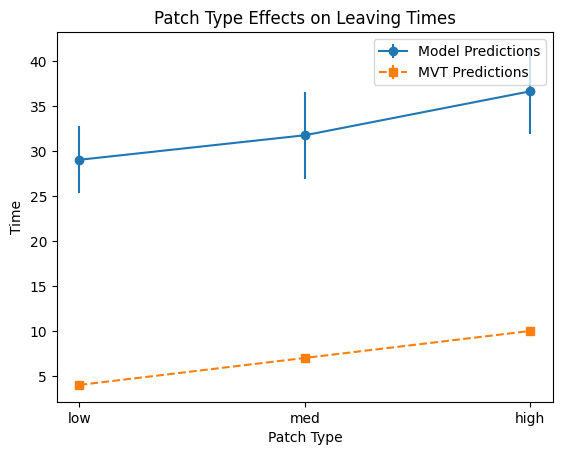

In [131]:
# Initialize environment
patches = initialize_patches()
agent = Agent(beta=0.9)

# Run simulations
leave_times = run_simulation(patches, agent)
mvt_leave_times = compute_mvt_predictions(patches)
print(leave_times)
print(mvt_leave_times)

# Organize results by patch type
results = {'low': [], 'med': [], 'high': []}
patch_types = {32.5: 'low', 45: 'med', 57.5: 'high'}
for patch, time, mvt_time in zip(patches, leave_times, mvt_leave_times):
    patch_type = patch_types[patch.initial_yield]
    results[patch_type].append((time, mvt_time))

# Calculate mean and variance for each patch type for both model and MVT predictions
model_means = {pt: np.mean([x[0] for x in results[pt]]) for pt in results}
model_variances = {pt: np.var([x[0] for x in results[pt]]) for pt in results}
mvt_means = {pt: np.mean([x[1] for x in results[pt]]) for pt in results}
mvt_variances = {pt: np.var([x[1] for x in results[pt]]) for pt in results}

# Plot results
patch_types = ['low', 'med', 'high']
model_mean_values = [model_means[pt] for pt in patch_types]
model_variance_values = [model_variances[pt] for pt in patch_types]
mvt_mean_values = [mvt_means[pt] for pt in patch_types]
mvt_variance_values = [mvt_variances[pt] for pt in patch_types]

plt.errorbar(patch_types, model_mean_values, yerr=np.sqrt(model_variance_values), fmt='o-', label='Model Predictions')
plt.errorbar(patch_types, mvt_mean_values, yerr=np.sqrt(mvt_variance_values), fmt='s--', label='MVT Predictions')
plt.title('Patch Type Effects on Leaving Times')
plt.xlabel('Patch Type')
plt.ylabel('Time')
plt.legend()
plt.show()

In [132]:
# Function to initialize patches with specified distribution among types
def initialize_environmental_patches(num_patches=100, environment='rich'):
    yields = {'low': 32.5, 'med': 45, 'high': 57.5}
    proportions = {
        'rich': {'low': 0.15, 'med': 0.20, 'high': 0.65},
        'poor': {'low': 0.65, 'med': 0.20, 'high': 0.15}
    }
    patch_distribution = ([yields['low']] * int(num_patches * proportions[environment]['low']) +
                          [yields['med']] * int(num_patches * proportions[environment]['med']) +
                          [yields['high']] * int(num_patches * proportions[environment]['high']))
    shuffle(patch_distribution)
    patches = [Patch(yield_value, decay_rate=0.1) for yield_value in patch_distribution]
    return patches

In [133]:
# Function to run simulation and compute MVT predictions
def simulate_and_predict(patches, agent):
    leave_times = run_simulation(patches, agent)
    mvt_leave_times = compute_mvt_predictions(patches)

    # Organize results by patch type
    results = {'low': [], 'med': [], 'high': []}
    patch_types = {32.5: 'low', 45: 'med', 57.5: 'high'}
    for patch, time, mvt_time in zip(patches, leave_times, mvt_leave_times):
        patch_type = patch_types[patch.initial_yield]
        results[patch_type].append((time, mvt_time))

    # Calculate mean and variance for both model and MVT predictions
    model_means = {pt: np.mean([x[0] for x in results[pt]]) for pt in results}
    model_variances = {pt: np.var([x[0] for x in results[pt]]) for pt in results}
    mvt_means = {pt: np.mean([x[1] for x in results[pt]]) for pt in results}
    mvt_variances = {pt: np.var([x[1] for x in results[pt]]) for pt in results}

    return model_means, model_variances, mvt_means, mvt_variances

In [136]:
# Initialize agents
agent = Agent(beta=1)

# Run simulations for both environments
environments = ['rich', 'poor']
environmental_results = {}
for env in environments:
    patches = initialize_environmental_patches(environment=env)
    initial_yields = [patch.initial_yield for patch in patches]
    print(initial_yields)
    environmental_results[env] = simulate_and_predict(patches, agent)

[57.5, 57.5, 57.5, 45, 57.5, 45, 57.5, 32.5, 57.5, 57.5, 57.5, 32.5, 32.5, 57.5, 57.5, 45, 32.5, 57.5, 45, 45, 57.5, 45, 57.5, 57.5, 45, 57.5, 57.5, 45, 32.5, 45, 45, 32.5, 32.5, 57.5, 57.5, 57.5, 57.5, 45, 57.5, 45, 57.5, 57.5, 57.5, 32.5, 57.5, 57.5, 57.5, 57.5, 57.5, 57.5, 57.5, 57.5, 57.5, 32.5, 32.5, 57.5, 45, 57.5, 45, 57.5, 57.5, 57.5, 32.5, 57.5, 57.5, 45, 57.5, 57.5, 57.5, 57.5, 57.5, 57.5, 57.5, 57.5, 32.5, 57.5, 57.5, 57.5, 57.5, 57.5, 45, 45, 45, 32.5, 57.5, 57.5, 57.5, 57.5, 57.5, 57.5, 57.5, 57.5, 32.5, 32.5, 57.5, 45, 57.5, 57.5, 45, 57.5]
512.5 22.748163043277035
[45, 32.5, 57.5, 32.5, 32.5, 45, 32.5, 32.5, 32.5, 32.5, 32.5, 45, 32.5, 32.5, 32.5, 32.5, 45, 32.5, 57.5, 32.5, 32.5, 32.5, 45, 32.5, 32.5, 32.5, 57.5, 32.5, 45, 32.5, 32.5, 57.5, 57.5, 32.5, 32.5, 57.5, 45, 32.5, 57.5, 45, 45, 32.5, 32.5, 32.5, 57.5, 45, 45, 32.5, 32.5, 45, 32.5, 32.5, 57.5, 45, 32.5, 32.5, 32.5, 32.5, 32.5, 32.5, 45, 57.5, 32.5, 32.5, 32.5, 32.5, 32.5, 32.5, 32.5, 32.5, 32.5, 32.5, 45, 32.5,

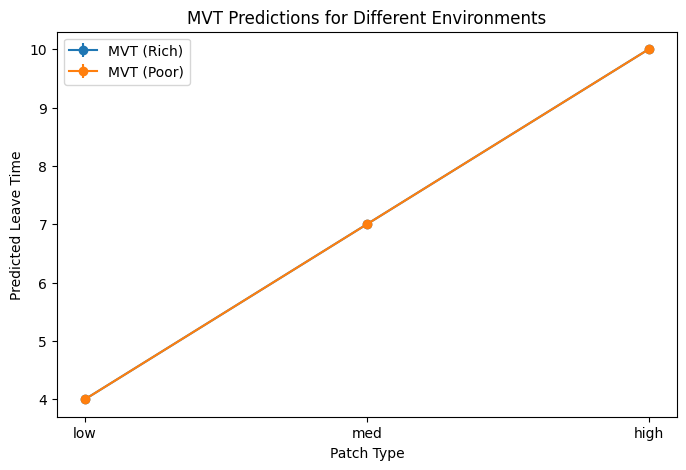

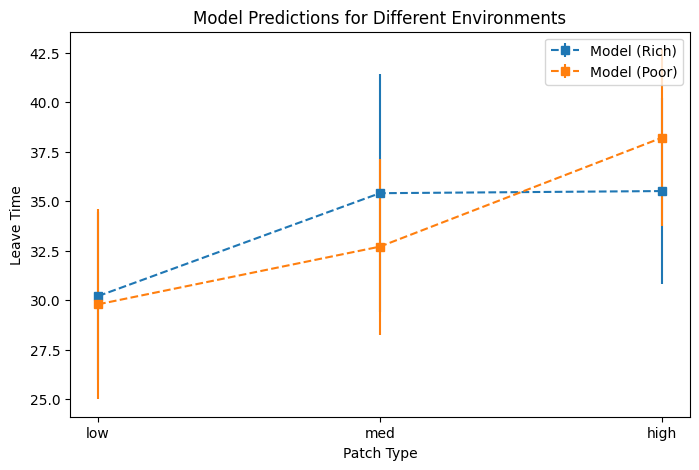

In [137]:
# Plotting
patch_types = ['low', 'med', 'high']

# Figure for MVT Predictions
plt.figure(figsize=(8, 5))
for env in environments:
    env_results = environmental_results[env]
    _, _, mvt_means, mvt_variances = env_results
    plt.errorbar(patch_types, [mvt_means[pt] for pt in patch_types], yerr=np.sqrt([mvt_variances[pt] for pt in patch_types]), fmt='o-', label=f'MVT ({env.capitalize()})')
plt.title('MVT Predictions for Different Environments')
plt.xlabel('Patch Type')
plt.ylabel('Predicted Leave Time')
plt.legend()
plt.show()

# Figure for Model Predictions
plt.figure(figsize=(8, 5))
for env in environments:
    env_results = environmental_results[env]
    model_means, model_variances, _, _ = env_results
    plt.errorbar(patch_types, [model_means[pt] for pt in patch_types], yerr=np.sqrt([model_variances[pt] for pt in patch_types]), fmt='s--', label=f'Model ({env.capitalize()})')
plt.title('Model Predictions for Different Environments')
plt.xlabel('Patch Type')
plt.ylabel('Leave Time')
plt.legend()
plt.show()